# Summary

1. Dimensionality reduction of data through PCA
2. (AR)HMM to quantify dynamics of (dim-reduced) activity

In [1]:
import os
import numpy as np
from scipy.stats import zscore
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

from ssm import HMM

import flygenvectors.plotting as plotting
import flygenvectors.utils as utils
import flygenvectors.data as dataUtils

In [2]:
sns.set_style('white')
sns.set_context('talk')

### load data

In [3]:
main_dir = '/Users/evan/Dropbox/_AxelLab/_flygenvectors_dataShare/'

# expt_id = '2019_06_30_fly1'
expt_id = '2019_07_01_fly2'

# options
# '190424_f3' (run+feed)
# '180824_f3r1'
# '2019_06_26_fly2'
# '2019_06_28_fly2'
# '2019_06_30_fly1'
# '2019_07_01_fly2'

data_dict = dataUtils.load_timeseries(expt_id,main_dir)

### preprocess data - split into training/testing sets

In [4]:
# get data from dict
indxs_flag = np.squeeze(data_dict['trialFlag'] < 2)
if expt_id == '190424_f3' or expt_id == '180824_f3r1':
    data_neural = data_dict['dOO'].T[indxs_flag]
    data_ball = data_dict['legs'].T[indxs_flag]
    data_feed = np.squeeze(data_dict['feed'].T[indxs_flag])
else:
    data_neural = data_dict['dFF'][indxs_flag]
    data_ball = data_dict['ball'][indxs_flag]
    data_feed = None
    
trialFlag = data_dict['trialFlag'][:len(data_ball)]

# preprocess neural data
from scipy import signal
data_neural = signal.detrend(data_neural, axis=0)
data_neural = zscore(data_neural)
data_neural = dataUtils.cluster(data_neural)

if data_feed is not None and np.sum(data_feed) > 0:
    behavior = np.concatenate([data_ball[:, None], data_feed[:, None]], axis=1)
else:
    behavior = data_ball

/Users/evan/anaconda/envs/flygenvectors/lib/python3.6/site-packages/scipy/signal/signaltools.py:2535: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  coef, resids, rank, s = linalg.lstsq(A, newdata[sl])


In [5]:
# split into train/test trials
trial_len = 100  # length of pseudo-trials
n_trials = np.floor(data_neural.shape[0] / trial_len)
print(data_neural.shape[0])
indxs = utils.split_trials(
    n_trials, trials_tr=10, trials_val=2, trials_test=0, trials_gap=0)
data = {}
beh = {}
for dtype in ['train', 'test', 'val']:
    data_segs = []
    beh_segs = []
    
    for indx in indxs[dtype]:
        ibeg = indx*trial_len
        iend = indx*trial_len + trial_len
        if len(np.unique(trialFlag[ibeg:iend])) == 1:
            data_segs.append(data_neural[(indx*trial_len):(indx*trial_len + trial_len)])
            beh_segs.append(behavior[(indx*trial_len):(indx*trial_len + trial_len)])
    data[dtype] = data_segs
    beh[dtype] = beh_segs
# for PCA/regression
data['train_all'] = np.concatenate(data['train'], axis=0)
data['val_all'] = np.concatenate(data['val'], axis=0)
beh['train_all'] = np.concatenate(beh['train'], axis=0)
beh['val_all'] = np.concatenate(beh['val'], axis=0)

print(np.shape(data['train']))
print(data_neural.shape)

3247
(20, 100, 1172)
(3247, 1172)


### ARHMM with 2 discrete states, applied to one trial

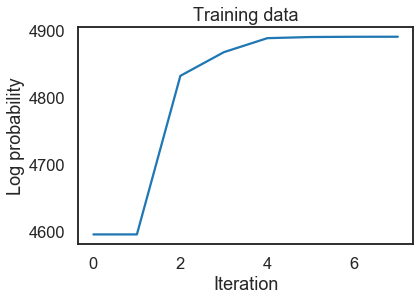

In [6]:
# first reduce dimensionality
data_pca_, data_pca = dataUtils.pca_reduce(data_neural, 10, indxs, trial_len)

model_kwargs = {'transitions': 'standard', 'observations': 'ar'}
# model_kwargs = {'transitions': 'standard', 'observations': 'gaussian'}
arhmm = HMM(K=2, D=data_pca['train'][0].shape[1], M=0, **model_kwargs)
arhmm.initialize(data_pca['train'])
arhmm.observations.initialize(data_pca['train'])

# run EM; specify tolerances for overall convergence and each M-step's convergence
logprobs = arhmm.fit(
    datas=data_pca['train'], 
    method='em', num_em_iters=50, tolerance=1e-1,
    transitions_mstep_kwargs={'optimizer': 'lbfgs', 'tol': 1e-3})

plt.figure()
plt.plot(logprobs)
plt.ylabel('Log probability')
plt.xlabel('Iteration')
plt.title('Training data')
plt.show()

### how well do these states match behavior?

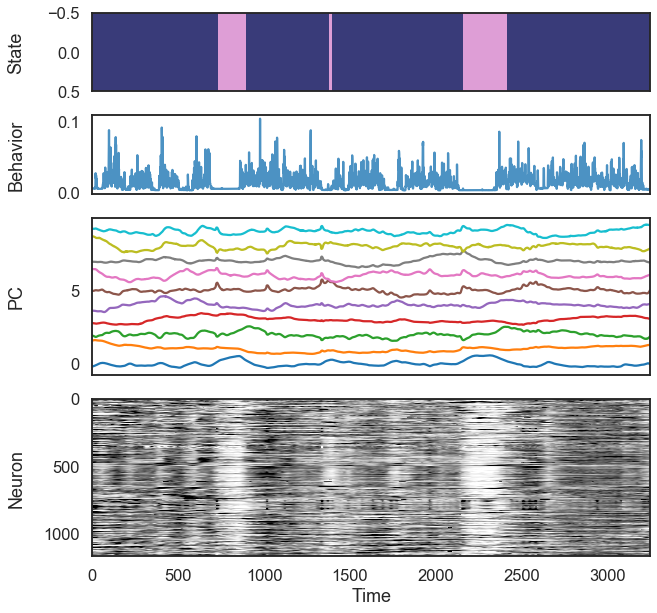

In [9]:
states_all = arhmm.most_likely_states(data_pca_)
# data_lowd = pca.transform(data_neural)    
fig = plotting.plot_neural_activity(
    pcs=zscore(data_pca_), neural_data=data_neural, behavior=behavior, states=states_all)

### ARHMM with 2 discrete states, applied to ALL trials

In [10]:
# get data from dict
indxs_flag = np.squeeze(data_dict['trialFlag'] < 5)
if expt_id == '190424_f3' or expt_id == '180824_f3r1':
    data_neural = data_dict['dOO'].T[indxs_flag]
    data_ball = data_dict['legs'].T[indxs_flag]
    data_feed = np.squeeze(data_dict['feed'].T[indxs_flag])
else:
    data_neural = data_dict['dFF'][indxs_flag]
    data_ball = data_dict['ball'][indxs_flag]
    data_feed = None
    
trialFlag = data_dict['trialFlag'][:len(data_ball)]

# preprocess neural data
from scipy import signal
data_neural = signal.detrend(data_neural, axis=0)
data_neural = zscore(data_neural)
data_neural = dataUtils.cluster(data_neural)

if data_feed is not None and np.sum(data_feed) > 0:
    behavior = np.concatenate([data_ball[:, None], data_feed[:, None]], axis=1)
else:
    behavior = data_ball

In [11]:
# split into train/test trials
trial_len = 100  # length of pseudo-trials
n_trials = np.floor(data_neural.shape[0] / trial_len)
print(data_neural.shape[0])
indxs = utils.split_trials(
    n_trials, trials_tr=10, trials_val=2, trials_test=0, trials_gap=0)
data = {}
beh = {}
for dtype in ['train', 'test', 'val']:
    data_segs = []
    beh_segs = []
    
    for indx in indxs[dtype]:
        ibeg = indx*trial_len
        iend = indx*trial_len + trial_len
        if len(np.unique(trialFlag[ibeg:iend])) == 1:
            data_segs.append(data_neural[(indx*trial_len):(indx*trial_len + trial_len)])
            beh_segs.append(behavior[(indx*trial_len):(indx*trial_len + trial_len)])
    data[dtype] = data_segs
    beh[dtype] = beh_segs
# for PCA/regression
data['train_all'] = np.concatenate(data['train'], axis=0)
data['val_all'] = np.concatenate(data['val'], axis=0)
beh['train_all'] = np.concatenate(beh['train'], axis=0)
beh['val_all'] = np.concatenate(beh['val'], axis=0)

print(np.shape(data['train']))
print(data_neural.shape)

9979
(78, 100, 1172)
(9979, 1172)


### evaluate on whole dataset without retraining

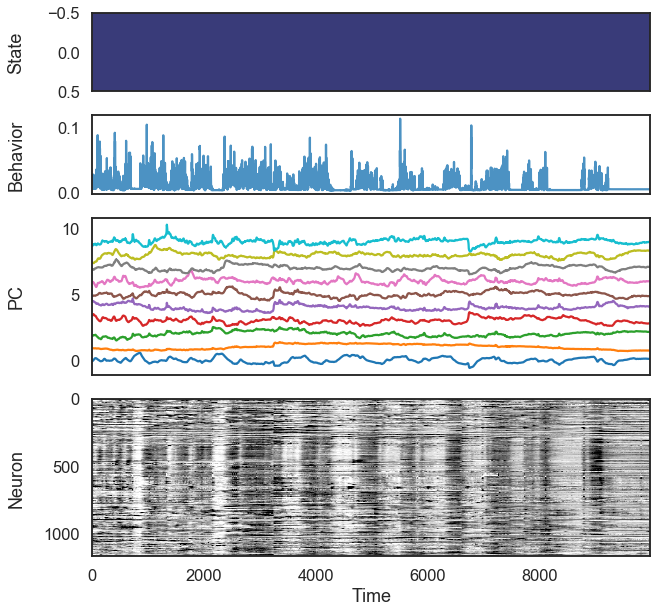

In [103]:
# first reduce dimensionality
data_pca_, data_pca = dataUtils.pca_reduce(data_neural, 10, indxs, trial_len)

# model_kwargs = {'transitions': 'standard', 'observations': 'ar'}
# # model_kwargs = {'transitions': 'standard', 'observations': 'gaussian'}
# arhmm = HMM(K=2, D=data_pca['train'][0].shape[1], M=0, **model_kwargs)
# arhmm.initialize(data_pca['train'])
# arhmm.observations.initialize(data_pca['train'])

# # run EM; specify tolerances for overall convergence and each M-step's convergence
# logprobs = arhmm.fit(
#     datas=data_pca['train'], 
#     method='em', num_em_iters=50, tolerance=1e-1,
#     transitions_mstep_kwargs={'optimizer': 'lbfgs', 'tol': 1e-3})

# plt.figure()
# plt.plot(logprobs)
# plt.ylabel('Log probability')
# plt.xlabel('Iteration')
# plt.title('Training data')
# plt.show()

states_all = arhmm.most_likely_states(data_pca_)
# states_all = np.random.randint(1, 3, size=(data_pca_.shape[0], ))
fig = plotting.plot_neural_activity(
    pcs=zscore(data_pca_), neural_data=data_neural, behavior=behavior, states=states_all,slc=(0,data_neural.shape[0]))

### retrain on whole dataset

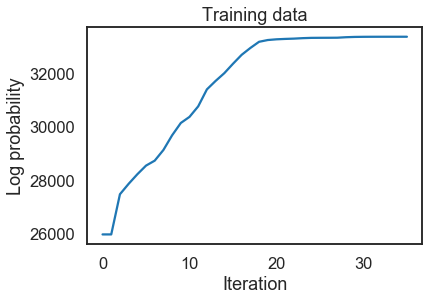

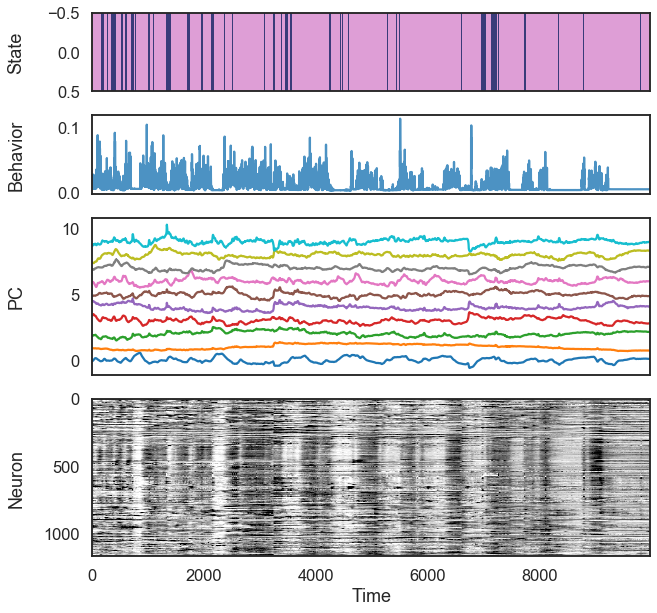

In [104]:
# first reduce dimensionality
data_pca_, data_pca = dataUtils.pca_reduce(data_neural, 10, indxs, trial_len)

model_kwargs = {'transitions': 'standard', 'observations': 'ar'}
# model_kwargs = {'transitions': 'standard', 'observations': 'gaussian'}
arhmm = HMM(K=2, D=data_pca['train'][0].shape[1], M=0, **model_kwargs)
arhmm.initialize(data_pca['train'])
arhmm.observations.initialize(data_pca['train'])

# run EM; specify tolerances for overall convergence and each M-step's convergence
logprobs = arhmm.fit(
    datas=data_pca['train'], 
    method='em', num_em_iters=50, tolerance=1e-1,
    transitions_mstep_kwargs={'optimizer': 'lbfgs', 'tol': 1e-3})

plt.figure()
plt.plot(logprobs)
plt.ylabel('Log probability')
plt.xlabel('Iteration')
plt.title('Training data')
plt.show()

states_all = arhmm.most_likely_states(data_pca_)
# states_all = np.random.randint(1, 3, size=(data_pca_.shape[0], ))
fig = plotting.plot_neural_activity(
    pcs=zscore(data_pca_), neural_data=data_neural, behavior=behavior, states=states_all,slc=(0,data_neural.shape[0]))

### retest on first run

In [108]:
# get data from dict
indxs_flag = np.squeeze(data_dict['trialFlag'] < 2)
if expt_id == '190424_f3' or expt_id == '180824_f3r1':
    data_neural = data_dict['dOO'].T[indxs_flag]
    data_ball = data_dict['legs'].T[indxs_flag]
    data_feed = np.squeeze(data_dict['feed'].T[indxs_flag])
else:
    data_neural = data_dict['dFF'][indxs_flag]
    data_ball = data_dict['ball'][indxs_flag]
    data_feed = None
    
trialFlag = data_dict['trialFlag'][:len(data_ball)]

# preprocess neural data
from scipy import signal
data_neural = signal.detrend(data_neural, axis=0)
data_neural = zscore(data_neural)
data_neural = dataUtils.cluster(data_neural)

if data_feed is not None and np.sum(data_feed) > 0:
    behavior = np.concatenate([data_ball[:, None], data_feed[:, None]], axis=1)
else:
    behavior = data_ball

In [109]:
# split into train/test trials
trial_len = 100  # length of pseudo-trials
n_trials = np.floor(data_neural.shape[0] / trial_len)
print(data_neural.shape[0])
indxs = utils.split_trials(
    n_trials, trials_tr=10, trials_val=2, trials_test=0, trials_gap=0)
data = {}
beh = {}
for dtype in ['train', 'test', 'val']:
    data_segs = []
    beh_segs = []
    
    for indx in indxs[dtype]:
        ibeg = indx*trial_len
        iend = indx*trial_len + trial_len
        if len(np.unique(trialFlag[ibeg:iend])) == 1:
            data_segs.append(data_neural[(indx*trial_len):(indx*trial_len + trial_len)])
            beh_segs.append(behavior[(indx*trial_len):(indx*trial_len + trial_len)])
    data[dtype] = data_segs
    beh[dtype] = beh_segs
# for PCA/regression
data['train_all'] = np.concatenate(data['train'], axis=0)
data['val_all'] = np.concatenate(data['val'], axis=0)
beh['train_all'] = np.concatenate(beh['train'], axis=0)
beh['val_all'] = np.concatenate(beh['val'], axis=0)

print(np.shape(data['train']))
print(data_neural.shape)

3247
(20, 100, 1172)
(3247, 1172)


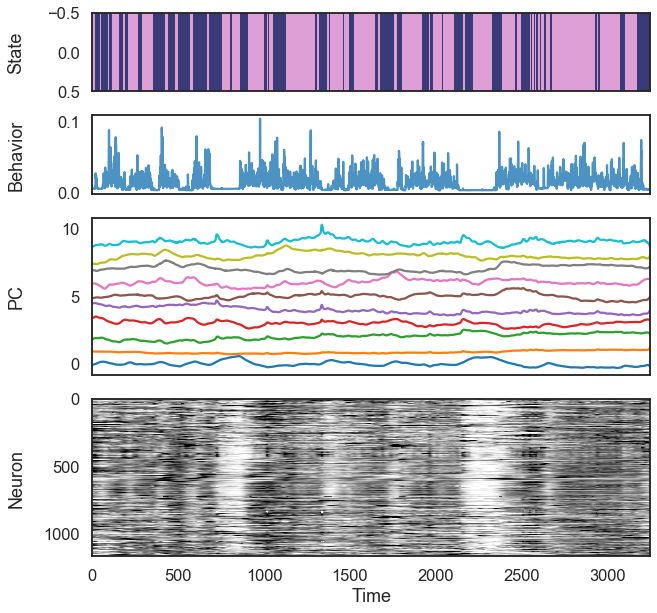

In [110]:
# first reduce dimensionality
data_pca_, data_pca = dataUtils.pca_reduce(data_neural, 10, indxs, trial_len)

# model_kwargs = {'transitions': 'standard', 'observations': 'ar'}
# # model_kwargs = {'transitions': 'standard', 'observations': 'gaussian'}
# arhmm = HMM(K=2, D=data_pca['train'][0].shape[1], M=0, **model_kwargs)
# arhmm.initialize(data_pca['train'])
# arhmm.observations.initialize(data_pca['train'])

# # run EM; specify tolerances for overall convergence and each M-step's convergence
# logprobs = arhmm.fit(
#     datas=data_pca['train'], 
#     method='em', num_em_iters=50, tolerance=1e-1,
#     transitions_mstep_kwargs={'optimizer': 'lbfgs', 'tol': 1e-3})

# plt.figure()
# plt.plot(logprobs)
# plt.ylabel('Log probability')
# plt.xlabel('Iteration')
# plt.title('Training data')
# plt.show()

states_all = arhmm.most_likely_states(data_pca_)
# states_all = np.random.randint(1, 3, size=(data_pca_.shape[0], ))
fig = plotting.plot_neural_activity(
    pcs=zscore(data_pca_), neural_data=data_neural, behavior=behavior, states=states_all,slc=(0,data_neural.shape[0]))

### train on 2nd run alone

In [125]:

# chose which trials to use (NoneType to default to all)
trial_flags = [2,] #[1, 2, 3]
if trial_flags is None:
    trial_flags = np.unique(data_dict['trialFlag'])
indxs_flag = np.full(shape=(data_dict['time'].shape[0],), fill_value=False)
for trial_flag in trial_flags:
    indxs_flag |= data_dict['trialFlag'][:, 0] == trial_flag
data_neural = data_dict['dFF'][indxs_flag]
data_ball = data_dict['ball'][indxs_flag]
beh = dict(
    x=zscore(data_dict['dlc'][:, 0::3]),
    y=zscore(data_dict['dlc'][:, 1::3]),
    l=data_dict['dlc'][:, 2::3])
data_dlc = np.concatenate([beh['x'], beh['y']], axis=1)

behavior = data_ball

In [126]:
# split into train/test trials
trial_len = 100  # length of pseudo-trials
n_trials = np.floor(data_neural.shape[0] / trial_len)
print(data_neural.shape[0])
indxs = utils.split_trials(
    n_trials, trials_tr=10, trials_val=2, trials_test=0, trials_gap=0)
data = {}
beh = {}
for dtype in ['train', 'test', 'val']:
    data_segs = []
    beh_segs = []
    
    for indx in indxs[dtype]:
        ibeg = indx*trial_len
        iend = indx*trial_len + trial_len
        if len(np.unique(trialFlag[ibeg:iend])) == 1:
            data_segs.append(data_neural[(indx*trial_len):(indx*trial_len + trial_len)])
            beh_segs.append(behavior[(indx*trial_len):(indx*trial_len + trial_len)])
    data[dtype] = data_segs
    beh[dtype] = beh_segs
# for PCA/regression
data['train_all'] = np.concatenate(data['train'], axis=0)
data['val_all'] = np.concatenate(data['val'], axis=0)
beh['train_all'] = np.concatenate(beh['train'], axis=0)
beh['val_all'] = np.concatenate(beh['val'], axis=0)

print(np.shape(data['train']))
print(data_neural.shape)

3366
(20, 100, 1172)
(3366, 1172)


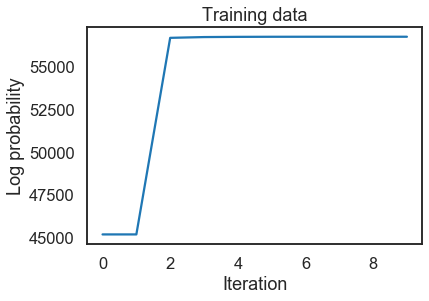

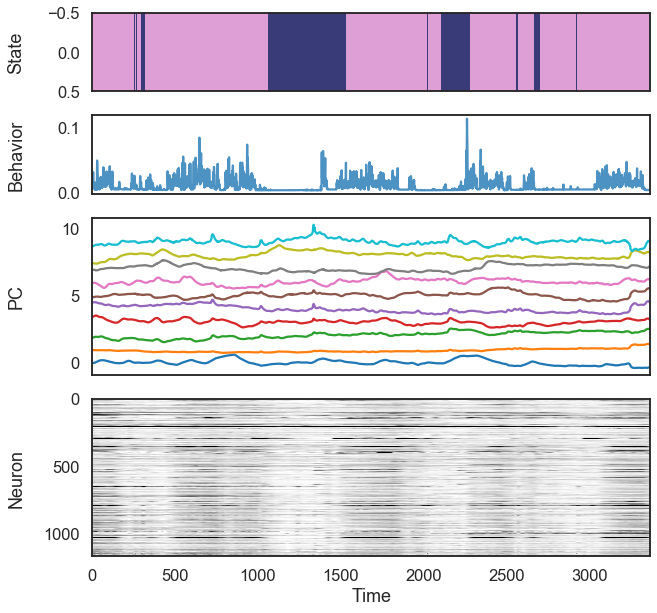

In [136]:
# first reduce dimensionality
data_pca_, data_pca = dataUtils.pca_reduce(data_neural, 10, indxs, trial_len)

model_kwargs = {'transitions': 'standard', 'observations': 'ar'}
# model_kwargs = {'transitions': 'standard', 'observations': 'gaussian'}
arhmm = HMM(K=2, D=data_pca['train'][0].shape[1], M=0, **model_kwargs)
arhmm.initialize(data_pca['train'])
arhmm.observations.initialize(data_pca['train'])

# run EM; specify tolerances for overall convergence and each M-step's convergence
logprobs = arhmm.fit(
    datas=data_pca['train'], 
    method='em', num_em_iters=50, tolerance=1e-1,
    transitions_mstep_kwargs={'optimizer': 'lbfgs', 'tol': 1e-3})

plt.figure()
plt.plot(logprobs)
plt.ylabel('Log probability')
plt.xlabel('Iteration')
plt.title('Training data')
plt.show()

states_all = arhmm.most_likely_states(data_pca_)
# states_all = np.random.randint(1, 3, size=(data_pca_.shape[0], ))
fig = plotting.plot_neural_activity(
    pcs=zscore(data_pca_), neural_data=data_neural, behavior=behavior, states=states_all,slc=(0,data_neural.shape[0]))